In [1]:
import time
initial_start_time = time.time()

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn


import torch
device = torch.device("cuda")

In [2]:
torch.random.manual_seed(1602)
torch.randn(1).item() # should print -0.1493116319179535

-0.1493116319179535

In [3]:
DATA_DIR = "data"
BATCH_SIZE = 16384

training_data = MNIST(DATA_DIR, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 128, 3),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Dropout(),

    nn.Conv2d(128, 128, 3),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Dropout(),


    nn.Flatten(),

    nn.Linear(3200, 128),
    nn.Dropout(),
    nn.Linear(128, 10),

).to(device)

model = torch.compile(model)

In [5]:
batches = []
for images, labels in tqdm(train_dataloader, desc="loading all data to gpu."):
  batches.append((images.to(device), labels.to(device)))

loading all data to gpu.: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


In [6]:
optimizer = optim.Adam(model.parameters())
crossentropy = nn.CrossEntropyLoss()

In [7]:
!rm -rf checkpoints
!mkdir checkpoints
speed = []
loss_history = []

scaler = torch.amp.GradScaler('cuda')
with torch.amp.autocast('cuda'):
  for t in range(len(batches)*100):
    start_time = time.time()

    images, labels = batches[t%(len(batches))]

    optimizer.zero_grad()

    predictions = model(images)
    loss = crossentropy(predictions, labels)
    loss_history.append(loss.item())

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    end_time = time.time()

    if t % 50 == 0:
      torch.save({
          'epoch': t,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
      }, f'checkpoints/checkpoint-{t}-loss={loss:.5f}.pth')
      print(f"saving checkpoint, #{t}, loss: {loss:.5f}")

    speed.append(images.shape[0]/(end_time-start_time))
    print(f"#{t}, loss: {loss:.15f}, speed: {speed[-1]:.2f} imgs/s, iter-time: {end_time-start_time:.2f}s, total-time-spent: {end_time-initial_start_time:.2f}")

W0622 15:27:34.490000 339 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


saving checkpoint, #0, loss: 2.61933
#0, loss: 2.619331121444702, speed: 421.43 imgs/s, iter-time: 38.88s, total-time-spent: 66.67
#1, loss: 4.049979209899902, speed: 36011.14 imgs/s, iter-time: 0.45s, total-time-spent: 67.15
#2, loss: 4.032312393188477, speed: 43641.97 imgs/s, iter-time: 0.38s, total-time-spent: 67.52
#3, loss: 3.095483064651489, speed: 500.78 imgs/s, iter-time: 21.66s, total-time-spent: 89.19
#4, loss: 2.618936538696289, speed: 24590.11 imgs/s, iter-time: 0.67s, total-time-spent: 89.85
#5, loss: 2.187489271163940, speed: 35423.93 imgs/s, iter-time: 0.46s, total-time-spent: 90.32
#6, loss: 2.220566749572754, speed: 25866.78 imgs/s, iter-time: 0.63s, total-time-spent: 90.95
#7, loss: 1.842676043510437, speed: 34499.56 imgs/s, iter-time: 0.31s, total-time-spent: 91.27
#8, loss: 1.280581951141357, speed: 35485.35 imgs/s, iter-time: 0.46s, total-time-spent: 91.73
#9, loss: 0.934788942337036, speed: 32887.65 imgs/s, iter-time: 0.50s, total-time-spent: 92.23
#10, loss: 0.74

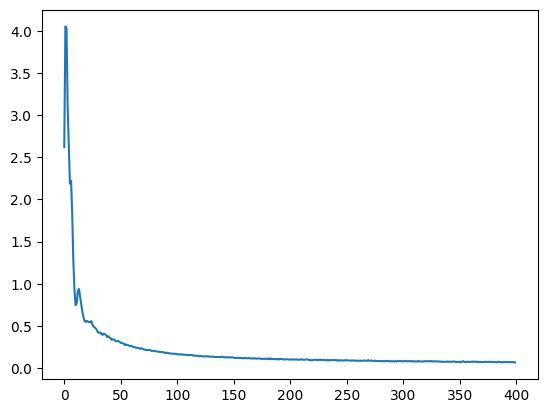

In [8]:
plt.plot(loss_history)

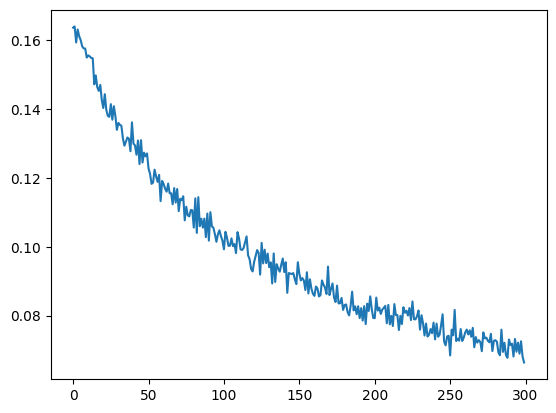

In [9]:
plt.plot(loss_history[100:])

# Testing

In [10]:
test_data = MNIST(DATA_DIR, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
model.eval()
with torch.no_grad():
  test_images, test_labels = next(iter(test_dataloader));
  test_images, test_labels = test_images.to(device), test_labels.to(device)

  predictions = model(test_images)
  loss = crossentropy(predictions, test_labels)
  accuracy = ((predictions.argmax(1) == test_labels).sum() / test_labels.shape[0]).item() * 100

**Final Result**

In [12]:
torch.save(model.state_dict(), f'model_weights-loss={loss:.5f}.pth')

In [13]:
print(f"final-loss: {loss:.10f}, final-accu: {accuracy:.3f}%, speed: {sum(speed)/len(speed):.2f} imgs/s, total-time-spent: {(time.time()-initial_start_time)/60:.2f} mins")

final-loss: 0.0387304276, final-accu: 98.760%, speed: 34428.52 imgs/s, total-time-spent: 4.45 mins
